In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pdf = pd.read_csv("pull_requests.csv")

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (77,99) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


https://developer.github.com/v3/pulls/#list-pull-requests
* "state": "open",
* "created_at": "2011-01-26T19:01:12Z",
* "closed_at": "2011-01-26T19:01:12Z",
* "merged_at": "2011-01-26T19:01:12Z",

In [4]:
psub = pdf[['user.login', 'state', 'created_at', 'closed_at', 'merged_at']].copy()
psub['created'] = pd.to_datetime(psub['created_at'])

In [5]:
psub.columns

Index(['user.login', 'state', 'created_at', 'closed_at', 'merged_at',
       'created'],
      dtype='object')

In [6]:
psub.groupby('user.login').agg({'user.login':'count', 'created_at':'max'}).sort_values(by='created_at', 
                                                                                       ascending=False)

,user.login,created_at
user.login,,
story645,24,2019-07-21T20:06:43Z
meeseeksmachine,526,2019-07-21T16:37:58Z
timhoffm,398,2019-07-20T15:26:04Z
dstansby,306,2019-07-19T22:04:17Z
bingyao,11,2019-07-19T14:41:29Z
Carreau,24,2019-07-19T04:30:16Z
abhinavsagar,5,2019-07-18T18:52:41Z
anntzer,1486,2019-07-18T18:12:47Z
Haloxxx,2,2019-07-18T15:25:14Z


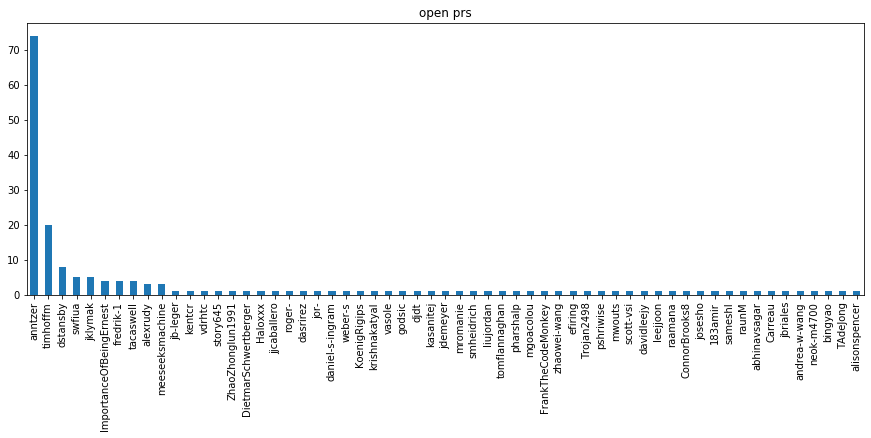

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("open prs")
_ = psub[(psub['created_at']>'2018-07-17') & 
         psub['state'].str.match('open')]['user.login'].value_counts().plot.bar(ax=ax)

In [11]:
#drop bot
psub = psub[~psub['user.login'].str.match('meeseeksmachine')]

In [12]:
merge_rate = pd.to_datetime(psub['merged_at']) - pd.to_datetime(psub['created_at'])
merge_rate.describe()

count                       6937
mean     15 days 22:07:28.792129
std      57 days 13:10:23.177546
min              0 days 00:00:05
25%              0 days 06:03:15
50%              1 days 06:11:17
75%              7 days 07:29:37
max           1172 days 02:46:16
dtype: object

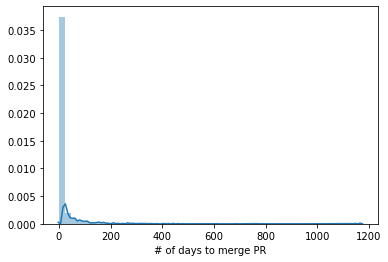

In [13]:
import seaborn as sns
fig, ax = plt.subplots()
_ = sns.distplot(merge_rate.dropna(how='all').dt.days, ax=ax)
_ = ax.set_xlabel("# of days to merge PR")

In [15]:
p2019 = psub[psub['created']>'2018-07-1'].copy()

In [16]:
ppr = p2019.groupby([pd.Grouper(key='created', freq='m'), 'state']).count()

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


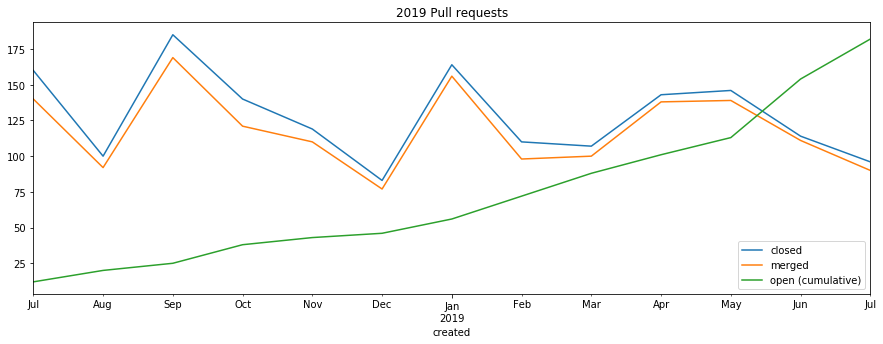

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("2019 Pull requests")
_ = ppr['created_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = ppr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
_ = ppr['created_at'].unstack()['open'].cumsum().plot(ax=ax, label='open (cumulative)') 
_ = ax.legend()

In [18]:
pre2019 = psub[(psub['created_at']<='2018-07-1') & psub['state'].str.match('open')]['state'].count()

In [19]:
opened = p2019.groupby(pd.Grouper(key='created', freq='M'))['created_at'].count()

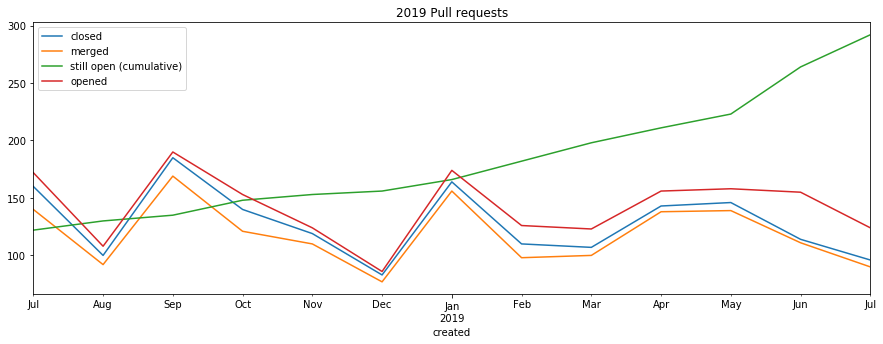

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("2019 Pull requests")
_ = ppr['created_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = ppr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
_ = (ppr['created_at'].unstack()['open'].cumsum() + pre2019).plot(ax=ax, label='still open (cumulative)')
_ = opened.plot(ax=ax, label='opened')
    
_ = ax.legend()

In [22]:
psub.columns

Index(['user.login', 'state', 'created_at', 'closed_at', 'merged_at',
       'created'],
      dtype='object')

In [23]:
pdr = psub.groupby([pd.Grouper(key='created', freq='m'), 'state']).count()
all_opened = psub.groupby(pd.Grouper(key='created', freq='m'))['created'].count()

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


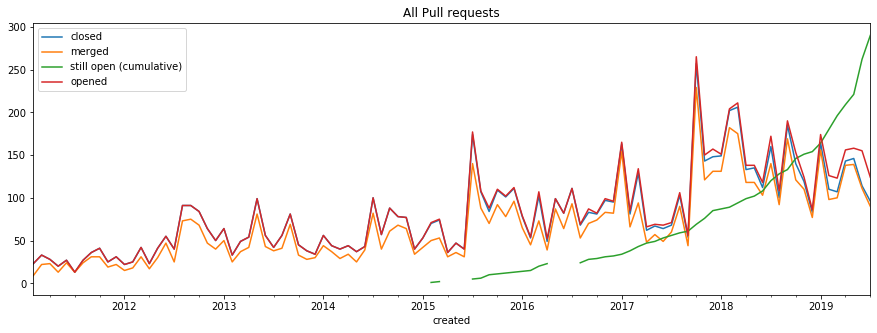

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("All Pull requests")
_ = pdr['created_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = pdr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
_ = pdr['created_at'].unstack()['open'].cumsum().plot(ax=ax, label='still open (cumulative)') 
_ = all_opened.plot(label = "opened")
_ = ax.legend()

In [ ]:
pdf[pdf['user.login'].str.match('meeseeksmachine')][['created_at','closed_at', 'merged_at']].count()

In [ ]:
523/526, 515/526

In [ ]:
pmonth = psub.groupby(pd.Grouper(key='created', freq='m')).count()
fig, ax = plt.subplots()
_ = (pmonth['closed_at']/pmonth['created_at']).plot(ax=ax, label="close rate")
_ = (pmonth['merged_at']/pmonth['created_at']).plot(ax=ax, label="merge rate")
_ = ax.legend()

In [ ]:
pmonth = psub.groupby(pd.Grouper(key='created', freq='m')).count()
fig, ax = plt.subplots()
_ = (pmonth['closed_at']/pmonth['created_at']).plot(ax=ax, label="close rate")
_ = (pmonth['merged_at']/pmonth['created_at']).plot(ax=ax, label="close rate")
_ = ax.legend()
_ = ax.set_xlim(['2018-07','2019-07'])

In [ ]:
pmonth.index